# Projet DALAS 
## CLASSIFICATION
### SOYKOK Aylin - CELIK Simay



But : Apprentissage sur la classification des items (fast or slow)

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
import shap
from itertools import combinations

In [2]:
df_fast = pd.read_pickle('../data/fastfashion_clean.pkl')
df_slow = pd.read_pickle('../data/slowfashion_clean.pkl')
base = pd.read_pickle('base.pkl')

In [3]:
base.head()

,Product Type,Product Name,Price,Materials,Country,Brand Type
0,Jeans,Pantalon cargo en denim,29.99,"[Cotton, Recycled cotton]",[Bangladesh],Fast Fashion
1,Jeans,Ultra High Ankle Jeggings,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[China],Fast Fashion
2,Jeans,Wide High Jeans,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],Fast Fashion
5,Jeans,Wide High Cropped Jeans,25.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],Fast Fashion
6,Jeans,Curvy Fit Slim High Jeans,35.99,"[Cotton, Recycled cotton, Polyester, Elastane]",[Bangladesh],Fast Fashion


In [4]:
X = base.drop(columns=['Brand Type','Product Name']) 
X = pd.get_dummies(X, columns=['Product Type'])
Y = base['Brand Type'].map({'Slow Fashion': 0, 'Fast Fashion': 1})


In [5]:
X.head()

,Price,Materials,Country,Product Type_Jeans,Product Type_Pantalons,Product Type_Tops
0,29.99,"[Cotton, Recycled cotton]",[Bangladesh],True,False,False
1,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[China],True,False,False
2,29.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],True,False,False
5,25.99,"[Cotton, Recycled cotton, Polyester, Recycled ...",[Bangladesh],True,False,False
6,35.99,"[Cotton, Recycled cotton, Polyester, Elastane]",[Bangladesh],True,False,False


In [6]:
# normalizing the material names
X['Materials'] = X['Materials'].apply(lambda x: [item.replace('Recycled polyester exclusive of ornamentation', 'Recycled polyester').replace('Recycled polyester of textile origin', 'Recycled polyester').replace('Lyocell Tencel™', 'Tencel lyocell') for item in x])

In [7]:
X['Materials'].explode().value_counts()

Materials
Elastane                      956
Polyester                     830
Cotton                        826
Recycled polyester            715
Viscose                       407
Recycled cotton               379
Polyamide                     282
Organic cotton                178
LivaEco™ Viscose              165
Linen                         118
Recycled polyamide             94
Tencel lyocell                 54
European flax linen            51
Supima cotton                  47
LENZING™ ECOVERO™ Viscose      47
Silk                           42
Wool                           39
Acrylic                        30
Modal                          27
Lyocell                        23
Lenzing ecovero viscose        16
Polyurethane                   12
Metallized fiber               11
Recycled nylon                  9
Leather                         5
Elastomultiester                5
Mohair                          4
Repreve recycled polyester      4
Cashmere                        3
Tenc

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

transformed_column = mlb.fit_transform(X['Materials'])
df_transformed = pd.DataFrame(transformed_column, columns=mlb.classes_)
X_reset = X.drop('Materials', axis=1).reset_index(drop=True)
df_transformed_reset = df_transformed.reset_index(drop=True)

X_transformed = pd.concat([X_reset, df_transformed_reset], axis=1)

transformed_column = mlb.fit_transform(X_transformed['Country'])

df_transformed = pd.DataFrame(transformed_column, columns=mlb.classes_)

df_transformed.columns = 'Country_' + df_transformed.columns

X_reset = X_transformed.drop('Country', axis=1).reset_index(drop=True)
df_transformed_reset = df_transformed.reset_index(drop=True)

X_transformed = pd.concat([X_reset, df_transformed_reset], axis=1)

# binarizing bool columns so that Shap can work
boolean_columns = X_transformed.select_dtypes(include=['bool']).columns

X_transformed[boolean_columns] = X_transformed[boolean_columns].astype(int)

In [9]:
X_transformed.head()

,Price,Product Type_Jeans,Product Type_Pantalons,Product Type_Tops,Acetate,Acrylic,Cashmere,Circulose®,Copolyester,Cotton,...,Country_Korea,Country_Mexico,Country_Morocco,Country_Myanmar,Country_Pakistan,Country_Peru,Country_Romania,Country_Sri Lanka,Country_Turkey,Country_Vietnam
0,29.99,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,29.99,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,29.99,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,25.99,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,35.99,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# checking class distribution
class_counts = Y.value_counts()
print(class_counts)

Brand Type
1    1650
0     366
Name: count, dtype: int64


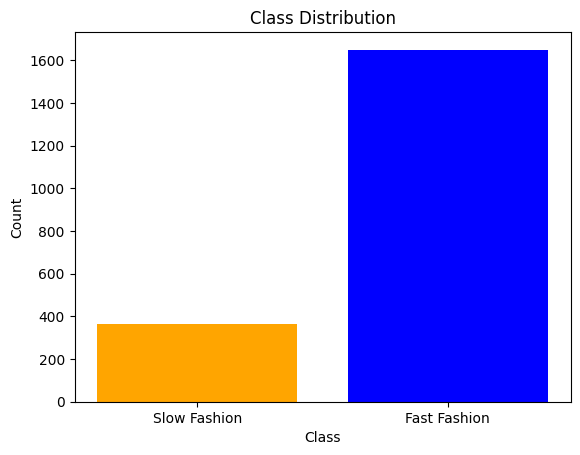

In [11]:
class_labels = ['Fast Fashion', 'Slow Fashion']

plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_counts.index, class_labels)
plt.show()

imbalanced class distribution

Basic classification methods

In [12]:
#training and test sets

# using stratify so that class distribution is preserved since we're imbalanced
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.2,  stratify=Y, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", Y_test.shape)

Shape of X_train: (1612, 61)
Shape of y_train: (1612,)
Shape of X_test: (404, 61)
Shape of y_test: (404,)


In [13]:
# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, Y_train)
dec_tree_pred = dec_tree.predict(X_test)

print(f"Decision Tree Accuracy: {accuracy_score(Y_test, dec_tree_pred)}")
precision = precision_score(Y_test, dec_tree_pred)
recall = recall_score(Y_test, dec_tree_pred)
f1 = f1_score(Y_test, dec_tree_pred)
auc_roc = roc_auc_score(Y_test, dec_tree_pred)
conf_matrix = confusion_matrix(Y_test, dec_tree_pred)

print(f"Decision Tree Precision: {precision}")
print(f"Decision Tree Recall: {recall}")
print(f"Decision Tree F1 Score: {f1}")
print(f"Decision Tree AUC-ROC Score: {auc_roc}")

Decision Tree Accuracy: 1.0
Decision Tree Precision: 1.0
Decision Tree Recall: 1.0
Decision Tree F1 Score: 1.0
Decision Tree AUC-ROC Score: 1.0


Decision Tree Confusion Matrix:


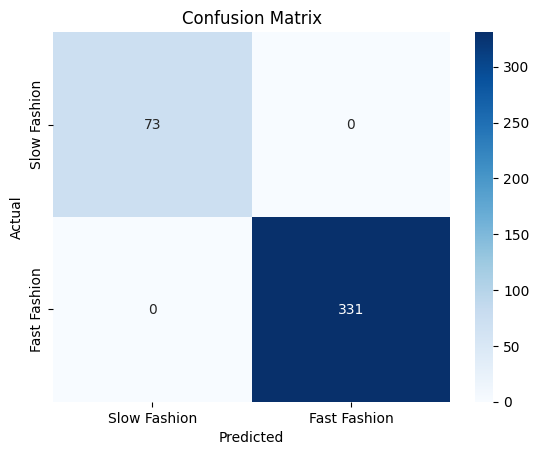

In [14]:
print("Decision Tree Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Slow Fashion', 'Fast Fashion'], yticklabels=['Slow Fashion', 'Fast Fashion'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# Random Forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, Y_train)
rand_forest_pred = rand_forest.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(Y_test, rand_forest_pred)}")
precision = precision_score(Y_test, rand_forest_pred)
recall = recall_score(Y_test, rand_forest_pred)
f1 = f1_score(Y_test, rand_forest_pred)
auc_roc = roc_auc_score(Y_test, rand_forest_pred)
conf_matrix = confusion_matrix(Y_test, rand_forest_pred)

print(f"Random Forest Precision: {precision}")
print(f"Random Forest Recall: {recall}")
print(f"Random Forest F1 Score: {f1}")
print(f"Random Forest AUC-ROC Score: {auc_roc}")

Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1 Score: 1.0
Random Forest AUC-ROC Score: 1.0


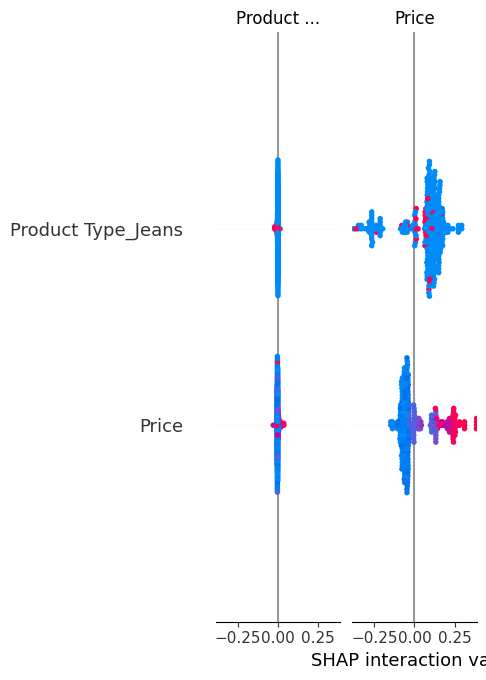

In [16]:
# shap values

rand_forest.fit(X_train, Y_train)
explainer = shap.Explainer(rand_forest)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Testons les différentes combinaisons d'attributs afin de voir comment ils effectuent les résultats obtenus par random forest.

In [69]:
#nous regroupons les features (selon leurs colonnes originales) pour voir leur impact
feature_groups = [('Price',['Price']),
                  ('Materials',['Acetate', 'Acrylic', 'Cashmere', 'Circulose®', 'Copolyester',
       'Cotton', 'Elastane', 'Elastomultiester', 'European flax linen',
       'LENZING™ ECOVERO™ Viscose', 'Leather', 'Lenzing ecovero viscose',
       'Linen', 'LivaEco™ Viscose', 'Lyocell', 'Metallized fiber', 'Modal',
       'Mohair', 'Organic cotton', 'Other fibers', 'Polyamide', 'Polyester',
       'Polyethylene terephthalate', 'Polyurethane', 'Recycled cotton',
       'Recycled nylon', 'Recycled polyamide', 'Recycled polyester',
       'Recycled wool', 'Regenerative cotton', 'Repreve recycled polyester',
       'Silk', 'Supima cotton', 'Tencel lyocell', 'Tencel with refibra',
       'Viscose', 'Wool', 'Yak wool']),
       ('Country',['Country_Bangladesh', 'Country_Bulgaria',
       'Country_Cambodia', 'Country_China', 'Country_Ethiopia',
       'Country_Guatemala', 'Country_India', 'Country_Indonesia',
       'Country_Kenya', 'Country_Korea', 'Country_Mexico', 'Country_Morocco',
       'Country_Myanmar', 'Country_Pakistan', 'Country_Peru',
       'Country_Romania', 'Country_Sri Lanka', 'Country_Turkey',
       'Country_Vietnam'])]



print("Random Forest Results By Groups of Features\n")
print("Group".ljust(30) + "Accuracy".ljust(10) + "Precision".ljust(10) + "Recall".ljust(10) + "F1 Score".ljust(10) + "AUC-ROC Score".ljust(15))

for r in range(1, len(feature_groups) + 1):
    for group_combination in combinations(feature_groups, r):
        group_ids = [group_id for group_id, _ in group_combination]
        group_features = [feature for _, features in group_combination for feature in features]

        current_X_train = X_train[group_features]
        current_X_test = X_test[group_features]
        rand_forest = RandomForestClassifier()
        rand_forest.fit(current_X_train, Y_train)
        rand_forest_pred = rand_forest.predict(current_X_test)

        precision = precision_score(Y_test, rand_forest_pred)
        recall = recall_score(Y_test, rand_forest_pred)
        f1 = f1_score(Y_test, rand_forest_pred)
        auc_roc = roc_auc_score(Y_test, rand_forest_pred)
        conf_matrix = confusion_matrix(Y_test, rand_forest_pred)

        print(f"{' & '.join(group_ids).ljust(30)}{accuracy_score(Y_test, rand_forest_pred):.2f}\t  {precision:.2f}\t   {recall:.2f}\t\t{f1:.2f}\t\t{auc_roc:.2f}")

Random Forest Results By Groups of Features

Group                         Accuracy  Precision Recall    F1 Score  AUC-ROC Score  
Price                         1.00	  1.00	   1.00		1.00		1.00
Materials                     0.97	  0.98	   0.99		0.98		0.94
Country                       0.97	  0.99	   0.98		0.98		0.96
Price & Materials             1.00	  0.99	   1.00		1.00		0.99
Price & Country               1.00	  1.00	   1.00		1.00		1.00
Materials & Country           1.00	  1.00	   1.00		1.00		1.00
Price & Materials & Country   1.00	  1.00	   1.00		1.00		1.00


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#  pipeline: first scales the data then applies LR
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

log_reg.fit(X_train, Y_train)
log_reg_pred = log_reg.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(Y_test, log_reg_pred)}")
precision = precision_score(Y_test, log_reg_pred)
recall = recall_score(Y_test, log_reg_pred)
f1 = f1_score(Y_test, log_reg_pred)
auc_roc = roc_auc_score(Y_test, log_reg_pred)
conf_matrix = confusion_matrix(Y_test, log_reg_pred)

print(f"Logistic Regression Precision: {precision}")
print(f"Logistic Regression Recall: {recall}")
print(f"Logistic Regression F1 Score: {f1}")
print(f"Logistic Regression AUC-ROC Score: {auc_roc}")

Logistic Regression Accuracy: 1.0
Logistic Regression Precision: 1.0
Logistic Regression Recall: 1.0
Logistic Regression F1 Score: 1.0
Logistic Regression AUC-ROC Score: 1.0


In [18]:
# cross validation for Logistic regression
cv_scores_logreg = cross_val_score(log_reg, X_train, Y_train, cv=5, scoring='roc_auc')

print("Cross-validation scores (AUC-ROC):", cv_scores_logreg)
print("Mean CV AUC-ROC:", cv_scores_logreg.mean())
print("Standard deviation of CV AUC-ROC:", np.std(cv_scores_logreg))

Cross-validation scores (AUC-ROC): [1. 1. 1. 1. 1.]
Mean CV AUC-ROC: 1.0
Standard deviation of CV AUC-ROC: 0.0


In [19]:
# feature importance for Logistic regression

log_reg.fit(X_train, Y_train)
coefficients = log_reg.named_steps['logisticregression'].coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# sort by absolute coefficient value
feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance[:10]) # top 10

               Feature  Coefficient  Absolute Coefficient
60     Country_Vietnam    -2.005387              2.005387
0                Price    -2.003484              2.003484
25           Polyester     1.401702              1.401702
58   Country_Sri Lanka    -1.331379              1.331379
24           Polyamide     1.041036              1.041036
31  Recycled polyester     0.994737              0.994737
45       Country_China     0.852672              0.852672
39             Viscose     0.707273              0.707273
22      Organic cotton    -0.617029              0.617029
14             Leather     0.555210              0.555210


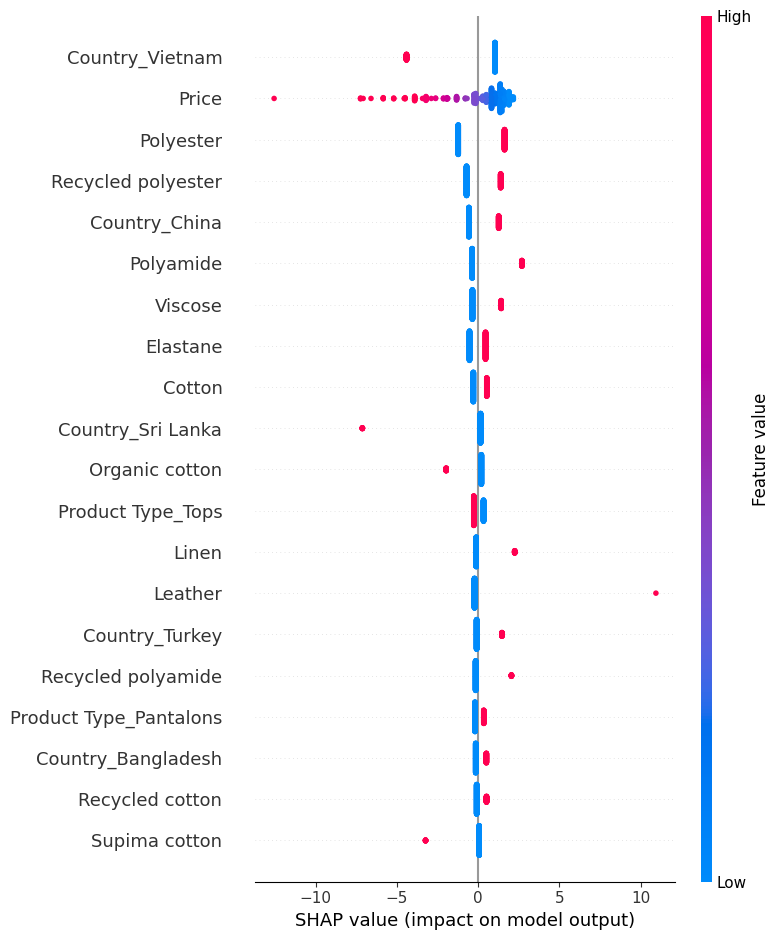

In [20]:
# shap values

log_reg_model = log_reg.named_steps['logisticregression']
scaler = log_reg.named_steps['standardscaler']
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

explainer = shap.Explainer(log_reg_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

In [70]:
#idem pour logreg
print("Logistic Regression Results By Groups of Features")
print("Group".ljust(30) + "Accuracy".ljust(10) + "Precision".ljust(10) + "Recall".ljust(10) + "F1 Score".ljust(10) + "AUC-ROC Score".ljust(15))


for r in range(1, len(feature_groups) + 1):
    for group_combination in combinations(feature_groups, r):
        group_ids = [group_id for group_id, _ in group_combination]
        group_features = [feature for _, features in group_combination for feature in features]

        current_X_train = X_train[group_features]
        current_X_test = X_test[group_features]
        log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

        log_reg.fit(current_X_train, Y_train)
        log_reg_pred = log_reg.predict(current_X_test)

        precision = precision_score(Y_test, log_reg_pred)
        recall = recall_score(Y_test, log_reg_pred)
        f1 = f1_score(Y_test, log_reg_pred)
        auc_roc = roc_auc_score(Y_test, log_reg_pred)
        conf_matrix = confusion_matrix(Y_test, log_reg_pred)

        print(f"{' & '.join(group_ids).ljust(30)}{accuracy_score(Y_test, log_reg_pred):.2f}\t  {precision:.2f}\t   {recall:.2f}\t\t{f1:.2f}\t\t{auc_roc:.2f}")

Logistic Regression Results By Groups of Features
Group                         Accuracy  Precision Recall    F1 Score  AUC-ROC Score  
Price                         0.91	  0.92	   0.97		0.95		0.79
Materials                     0.97	  0.97	   0.99		0.98		0.93
Country                       0.97	  0.99	   0.98		0.98		0.96
Price & Materials             0.98	  0.98	   0.99		0.99		0.95
Price & Country               1.00	  1.00	   1.00		1.00		1.00
Materials & Country           1.00	  1.00	   1.00		1.00		1.00
Price & Materials & Country   1.00	  1.00	   1.00		1.00		1.00


In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Create a KMeans instance with 3 clusters: kmeans
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit model to samples
kmeans.fit(X_scaled)

# Determine the cluster labels of new_points: labels
labels = kmeans.predict(X_scaled)

# Print cluster labels of X
print(labels)

[0 0 0 ... 0 0 0]


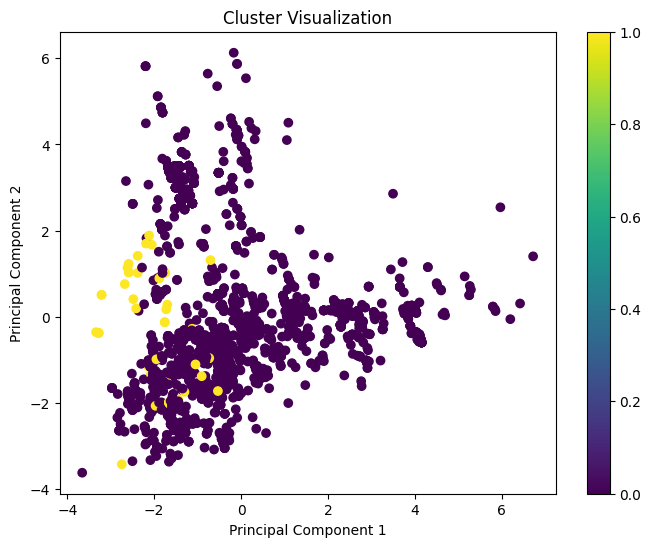

In [22]:
#using pca bcs too many dimensions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

plt.colorbar(scatter)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.show()

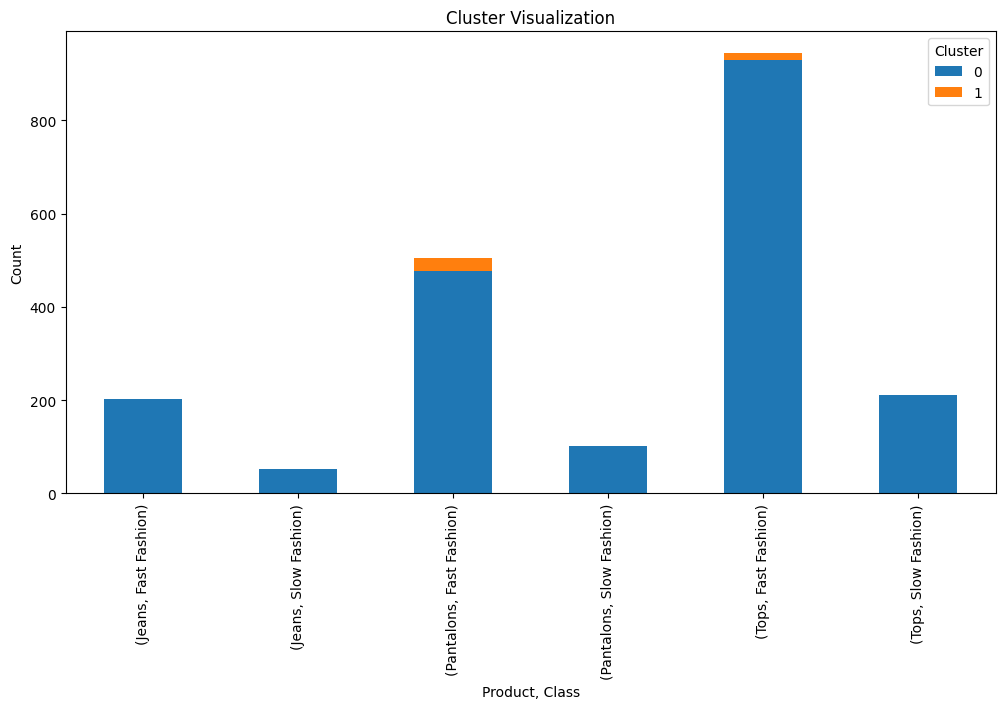

In [23]:
df_clusters = pd.DataFrame({
    'Product': base['Product Type'],
    'Class': base['Brand Type'],
    'Cluster': labels
})

df_clusters_grouped = df_clusters.groupby(['Product', 'Class', 'Cluster']).size().unstack(fill_value=0)

df_clusters_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Product, Class')
plt.ylabel('Count')
plt.title('Cluster Visualization')
plt.show()

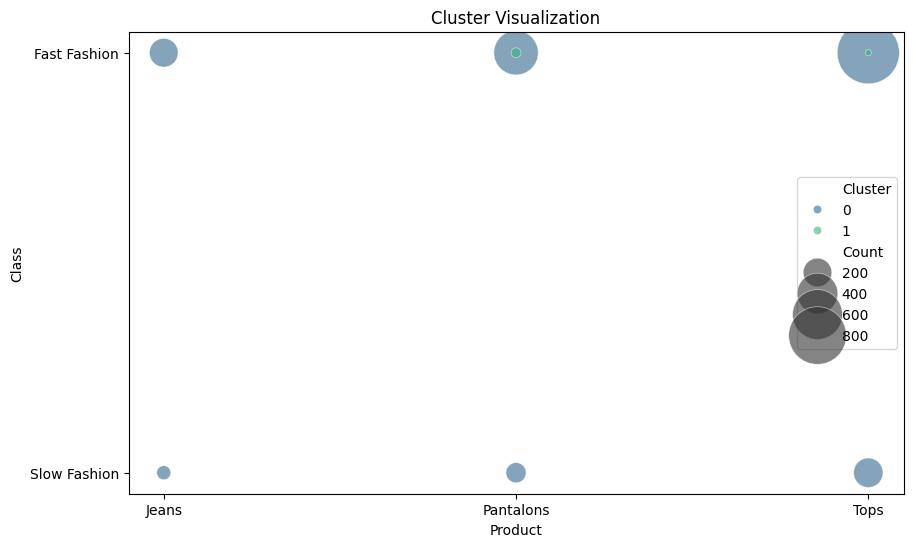

In [24]:
df_clusters = pd.DataFrame({
    'Product': base['Product Type'],
    'Class': base['Brand Type'],
    'Cluster': labels
})

# Group by 'Product' and 'Class' and count the number of instances in each cluster
df_clusters_grouped = df_clusters.groupby(['Product', 'Class', 'Cluster']).size().reset_index(name='Count')

# Create a bubble chart
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters_grouped, x='Product', y='Class', size='Count', hue='Cluster', palette='viridis', sizes=(20, 2000), alpha=0.6)

plt.xlabel('Product')
plt.ylabel('Class')
plt.title('Cluster Visualization')
plt.show()

In [25]:
svm = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))

svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(Y_test, svm_pred))
precision = precision_score(Y_test, svm_pred)
recall = recall_score(Y_test, svm_pred)
f1 = f1_score(Y_test, svm_pred)
auc_roc = roc_auc_score(Y_test, svm_pred)
conf_matrix = confusion_matrix(Y_test, svm_pred)

print(f"SVM Precision: {precision}")
print(f"SVM Recall: {recall}")
print(f"SVM F1 Score: {f1}")
print(f"SVM AUC-ROC Score: {auc_roc}")

SVM Accuracy: 0.9975247524752475
SVM Precision: 1.0
SVM Recall: 0.9969788519637462
SVM F1 Score: 0.9984871406959153
SVM AUC-ROC Score: 0.9984894259818731


SVM Confusion Matrix:


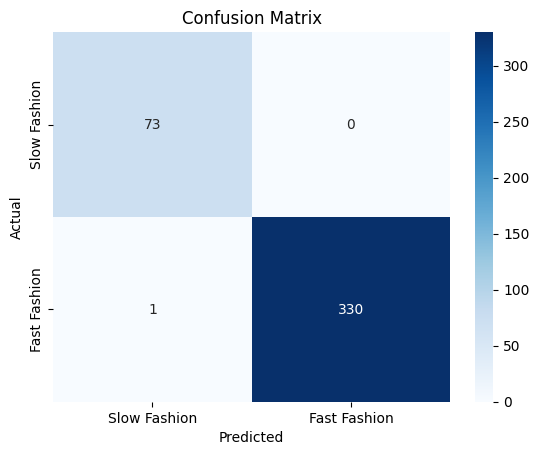

In [26]:
print("SVM Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Slow Fashion', 'Fast Fashion'], yticklabels=['Slow Fashion', 'Fast Fashion'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

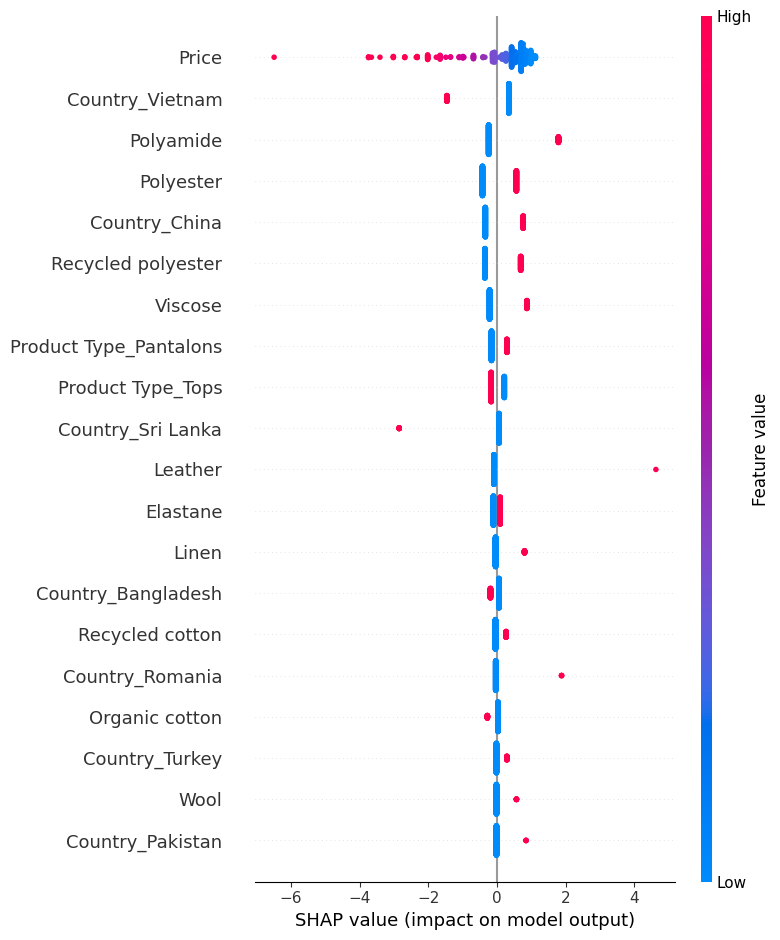

In [27]:
# shap values

svm_model = svm.named_steps['svc']
scaler = svm.named_steps['standardscaler']
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

explainer = shap.Explainer(svm_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

In [72]:
#idem pour  svm
print("SVM Results By Groups of Features")
print("Group".ljust(30) + "Accuracy".ljust(10) + "Precision".ljust(10) + "Recall".ljust(10) + "F1 Score".ljust(10) + "AUC-ROC Score".ljust(15))


for r in range(1, len(feature_groups) + 1):
    for group_combination in combinations(feature_groups, r):
        group_ids = [group_id for group_id, _ in group_combination]
        group_features = [feature for _, features in group_combination for feature in features]

        current_X_train = X_train[group_features]
        current_X_test = X_test[group_features]
        svm = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))

        svm.fit(current_X_train, Y_train)
        svm_pred = svm.predict(current_X_test)
        
        precision = precision_score(Y_test, svm_pred)
        recall = recall_score(Y_test, svm_pred)
        f1 = f1_score(Y_test, svm_pred)
        auc_roc = roc_auc_score(Y_test, svm_pred)
        conf_matrix = confusion_matrix(Y_test, svm_pred)

        print(f"{' & '.join(group_ids).ljust(30)}{accuracy_score(Y_test, log_reg_pred):.2f}\t  {precision:.2f}\t   {recall:.2f}\t\t{f1:.2f}\t\t{auc_roc:.2f}")

SVM Results By Groups of Features
Group                         Accuracy  Precision Recall    F1 Score  AUC-ROC Score  
Price                         1.00	  0.92	   0.97		0.95		0.79
Materials                     1.00	  0.98	   0.98		0.98		0.93
Country                       1.00	  0.99	   0.98		0.98		0.96
Price & Materials             1.00	  0.98	   0.99		0.99		0.95
Price & Country               1.00	  1.00	   1.00		1.00		1.00
Materials & Country           1.00	  1.00	   0.99		1.00		1.00
Price & Materials & Country   1.00	  1.00	   1.00		1.00		1.00


without the product types features

In [28]:
X_transformed_copy = X_transformed.copy()
X_transformed_copy = X_transformed_copy.drop(['Product Type_Jeans', 'Product Type_Pantalons', 'Product Type_Tops'], axis=1)

#training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed_copy, Y, test_size=0.2, random_state=42)

# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, Y_train)
dec_tree_pred = dec_tree.predict(X_test)
print(f"Decision Tree Accuracy: {accuracy_score(Y_test, dec_tree_pred)}")

# Random Forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, Y_train)
rand_forest_pred = rand_forest.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(Y_test, rand_forest_pred)}")

Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0


In [29]:
# Log reg
#  pipeline: first scales the data then applies LR
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

log_reg.fit(X_train, Y_train)
log_reg_pred = log_reg.predict(X_test)
print(f"Logistic Regression Accuracy: {accuracy_score(Y_test, log_reg_pred)}")

Logistic Regression Accuracy: 1.0
